In [1]:
import numpy as np, pandas as pd
from glob import glob
from astropy.table import Table
from matplotlib import pyplot as plt, colors as colors, colorbar as cbar
from astroquery.simbad import Simbad
import astropy.coordinates as coord
import astropy.units as u

%matplotlib inline

In [32]:
good = pd.read_csv('../data/bright_sample/massive.csv.gz')
len(good),good.columns

(6484,
 Index(['BP-RP', 'Galaxy', 'M_G', 'M_W1', 'W1-W2', 'W2-W3', 'W3-W4', 'a_g_val',
        'allwise_oid', 'dec', 'designation', 'original_ext_source_id',
        'parallax', 'parallax_error', 'phot_bp_mean_mag', 'phot_g_mean_mag',
        'phot_rp_mean_mag', 'r_est', 'r_hi', 'r_len', 'r_lo', 'ra', 'source_id',
        'w1mpro', 'w1mpro_error', 'w2mpro', 'w2mpro_error', 'w3mpro',
        'w3mpro_error', 'w4mpro', 'w4mpro_error', 'CommonName', 'MKType',
        'SimbadOType', 'SpT', 'Jmag', 'e_Jmag', 'Hmag', 'e_Hmag', 'Kmag',
        'e_Kmag', 'G-J', 'J-H', 'H-K', 'K-W1', 'J-W1'],
       dtype='object'))

In [33]:
#We need a list of LBVs because SIMBAD is bad at classifying LBVs
#Let's go with only confirmed LBVs from Richardson & Mehner (2018, RNAAS)

lbv_commonname1 = ['HD 90177','* eta Car','V* AG Car','MR 35','[GKM2012] WS1',
                   'WRAY 16-137','EM* VRMF   55','Cl* Westerlund 1 W 243','[GKF2010] MN48',
                   'HD 160529','[GKF2010] MN58','GCIRS 34W','[NHS93] 22','[GMC99] D6',
                   'HD 168607','EM* MWC 930','V* V481 Sct','IRAS 18576+0341','* P Cyg',
                   'HD 5980','HD 6884','HD 269006','HD 269216','V* S Dor','HD 269582',
                   'HD 269662','HD 269700','HD 269858','CPD-69   463']

lbv_commonname2 = ['V* HR Car','HD 93308','HD 94910','V* V432 Car',
                   'UCAC2 3729120','2MASS J13501536-6148552','[GKF2010] MN44',
                   '2MASS J16470749-4552290','2MASS J16493770-4535592','V* V905 Sco',
                   '2MASS J17374754-3137333','WR 101db','V* V4998 Sgr',
                   'V* V4650 Sgr','V* V4029 Sgr','V* V446 Sct','G24.73+0.69',
                   'V* V1672 Aql','HD 193237','RMC 14','RMC 40','RMC 71',
                   '2MASS J05133077-6932236','HD 35343','SV* HV 5495',
                   '2MASS J05305147-6902587','RMC 116','RMC 127','RMC 143']

lbv_gaia = [5255045082580350080,5350358580171706624,5338220285385672064,5337309477433273728,
            5864989022016713728,5865577604279098112,5940576971716473344,5940105830990286208,
            5940216130049700480,4053887521876855808,4055062727939772800,                  0,                  
                              0,                  0,4097791502146559872,4159973866869462784,
            4255908794692238848,                  0,2061242908036996352,4690516883290136832,
            4687436704549343488,4654621505126284288,4658204053297963392,4658193814095915776,
            4658481718680657792,4658431553453824256,4658474743652257664,4657655435693883776,
            4657679551902223616]

#Note: [GKF2010] MN58 is close to Gaia DR2 4055062727939772800 = 2MASS J17374754-3137333, 
#so we're calling them the same source

In [34]:
#Let's write a decision tree that classifies things

#LBV -> Binaries -> WRs -> Cool stars -> Warm stars -> Oe/Be (brackets?) -> OB supergiants/main sequence

classifications= []
for i,row in good.iterrows():
    # Pull out lbvs
    if (row['source_id'] in lbv_gaia) | (row['CommonName'] in lbv_commonname1) | (row['CommonName'] in lbv_commonname2):
        classifications.append('LBV')
    # Pull out remaining binaries
    elif ('EB' in str(row['SimbadOType'])) | ('SB' in str(row['SimbadOType'])) | ('Ellip' in str(row['SimbadOType'])) | ('HMXB' in str(row['SimbadOType'])) | ('+' in str(row['SpT'])[1:-2]) | (str(row['SpT']) == 'B+K'):
        classifications.append('Binary')
    # Pull out WRs. Note, we also get the Ofpe/WN9 LBV candidate HD 269445
    elif ('W' in str(row['SpT'])) | (row['SimbadOType'] == 'WR*'):
        classifications.append('WR')
    #Cool stars
    elif (str(row['SpT'])[0] in ['K','M']):
        classifications.append('RSG')
    #Warm stars
    elif (str(row['SpT'])[0] in ['F','G']):
        classifications.append('YSG')
    #O/B [e] stars
    elif '[e]' in str(row['SpT']):
        classifications.append('OB[e]')
    #O/B/A e stars
    elif np.any(['e' in foo for foo in str(row['SpT']).split('pec')]) | ('Em' in str(row['SimbadOType'])):
        classifications.append('OBAe')
    elif (str(row['SpT'])[0] in ['O','B','A']):
        #OBA subgiants and giants
        if ('IV' in str(row['SpT']))|('III' in str(row['SpT'])):
            classifications.append('EvolvedOBA')
        #OBA dwarfs
        elif 'V' in str(row['SpT']):
            classifications.append('MainSequenceOBA')
        #OBA bright giants and supergiants
        elif ('I' in str(row['SpT'])) | ('SG' in str(row['SimbadOType'])):
            classifications.append('SupergiantOBA')
        #Generic OBA
        else:
            classifications.append('OBA')
    #C and S stars
    elif ('C' in str(row['SpT'])) | (str(row['SimbadOType']) == 'C*'):
        classifications.append('CStar')
    elif 'S' in str(row['SpT']):
        classifications.append('SStar')
    #Everything else. This includes 'Candidate' other types, as well as LPVs, semi-regular Variables, etc.
    elif 'V*' in str(row['SimbadOType']):
        classifications.append('Misc. Variable')
    else:
        classifications.append('Unknown/Candidate')
print(len(classifications))

6484


In [35]:
classification_df = pd.DataFrame({'source_id':good['source_id'],
                                  'CommonName':good['CommonName'],
                                  'Class':classifications})
classification_df.to_csv('classifications.csv')

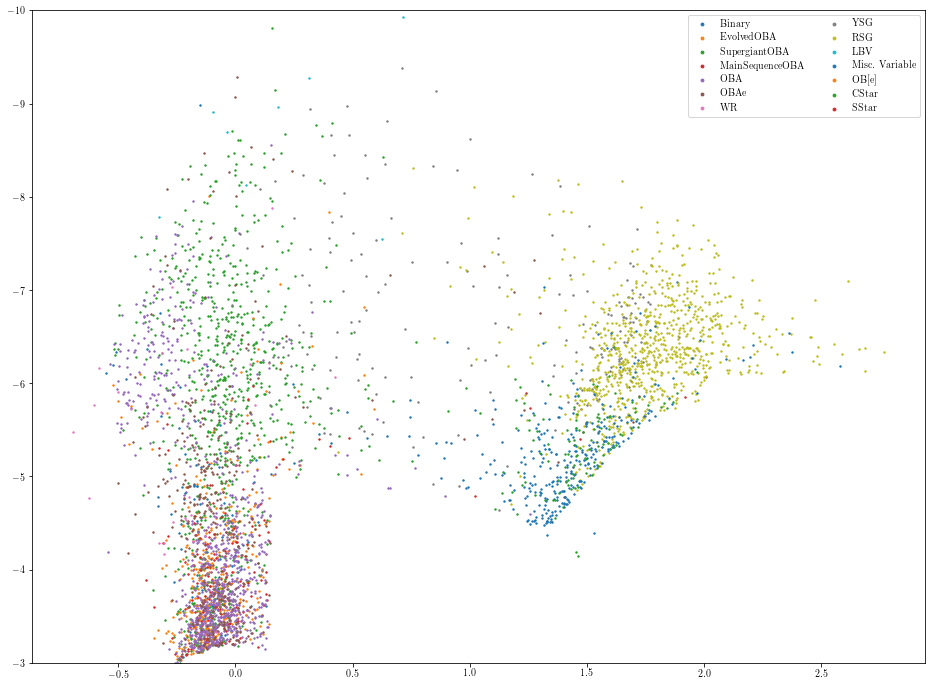

In [36]:
fig=plt.figure(figsize=(16,12))
joined = good.merge(classification_df,on='source_id')
for cl in joined['Class'].unique():
    if cl != 'Unknown/Candidate':
        plt.scatter(joined['BP-RP'][joined['Class']==cl],joined['M_G'][joined['Class']==cl],s=2,label=cl)
plt.ylim(-3,-10)
plt.legend(ncol=2,markerscale=2)

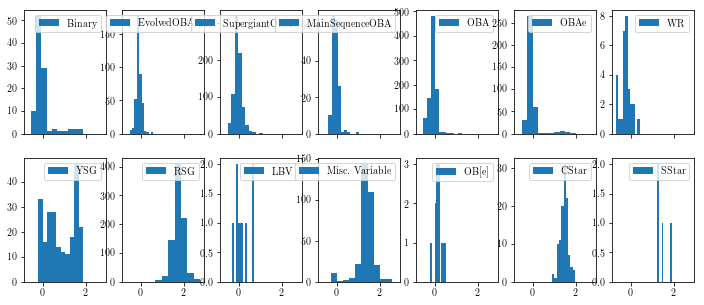

In [37]:
fig, ax = plt.subplots(2,7,figsize=(12,5),sharex=True)

for i,cl in enumerate(joined['Class'][joined['Class']!='Unknown/Candidate'].unique()):
    ax.flatten()[i].hist(joined['BP-RP'][joined['Class']==cl],label=cl)
    ax.flatten()[i].legend()

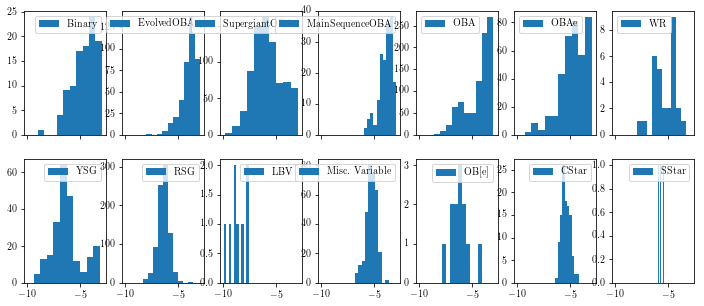

In [38]:
fig, ax = plt.subplots(2,7,figsize=(12,5),sharex=True)

for i,cl in enumerate(joined['Class'][joined['Class']!='Unknown/Candidate'].unique()):
    ax.flatten()[i].hist(joined['M_G'][joined['Class']==cl],label=cl)
    ax.flatten()[i].legend()

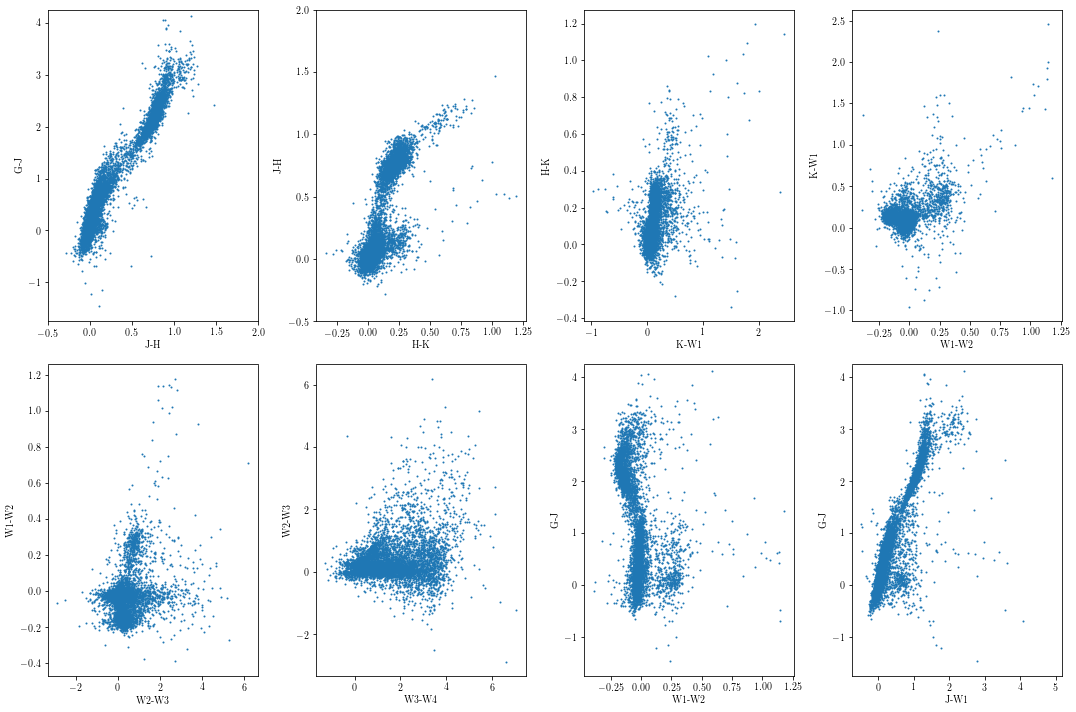

In [49]:
color_pairs = [['G-J','J-H'],['J-H','H-K'],['H-K','K-W1'],['K-W1','W1-W2'],['W1-W2','W2-W3'],
              ['W2-W3','W3-W4'],['G-J','W1-W2'],['G-J','J-W1']]
fig,axes = plt.subplots(2,4,figsize=(15,10))
for i,cp in enumerate(color_pairs):
    a = axes.flatten()[i]
    a.scatter(joined[cp[1]],joined[cp[0]],s=1)
    a.set(xlabel=cp[1],ylabel=cp[0])
ax = axes.flatten()
ax[0].set(xlim=(-0.5,2),ylim=(-1.75,4.25))
ax[1].set(ylim=(-0.5,2))
ax[6].set(ylim=(-1.75,4.25))
ax[7].set(ylim=(-1.75,4.25))
xlims = [a.get_xlim() for a in ax]
ylims = [a.get_ylim() for a in ax]
plt.tight_layout()

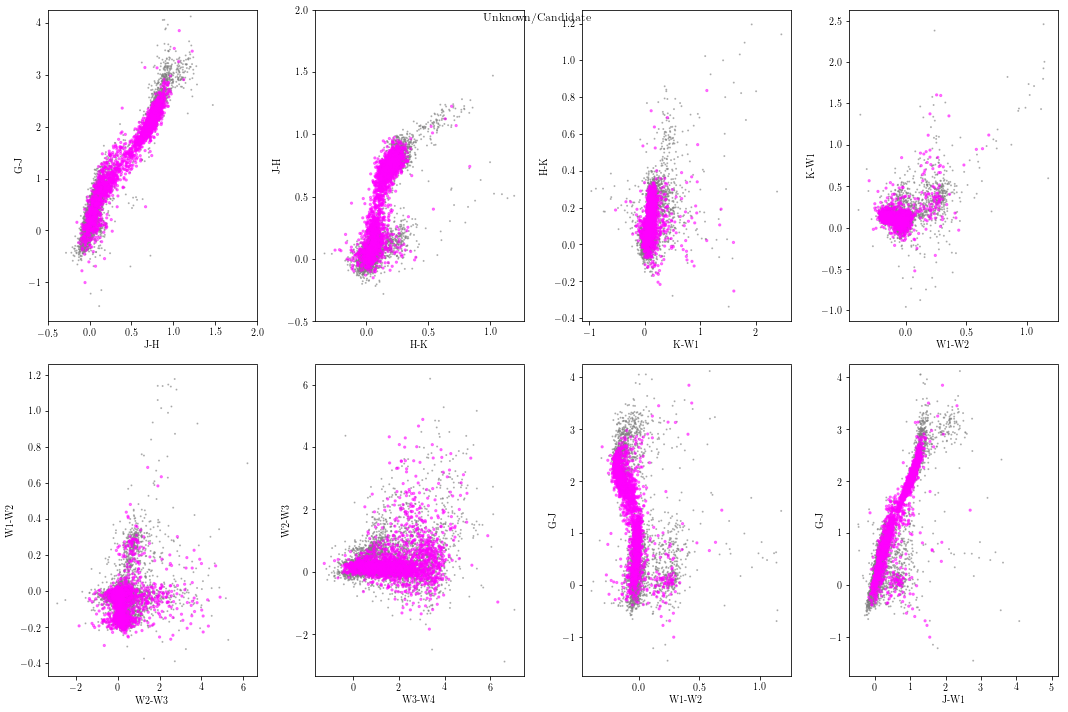

In [78]:
from matplotlib.animation import FuncAnimation, writers

fig, ax = plt.subplots(2,4,figsize=(15,10))

color_pairs = [['G-J','J-H'],['J-H','H-K'],['H-K','K-W1'],['K-W1','W1-W2'],['W1-W2','W2-W3'],
              ['W2-W3','W3-W4'],['G-J','W1-W2'],['G-J','J-W1']]
paths = [a.scatter([],[],s=1,c='k',alpha=0.5) for a in ax.flatten()]
color_arr = ['C{0}'.format(i) for i in range(10)] + ['blue','green','red','cyan','magenta']
classifications = ['OBA','MainSequenceOBA','EvolvedOBA','SupergiantOBA','OBAe','OB[e]','YSG',
                   'RSG','WR','LBV','Binary','CStar','Sstar','Misc. Variable',
                   'Unknown/Candidate']
frames = [i for i in range(len(color_arr))]

def init():
    paths = []
    colors = ['grey' for i in range(len(joined))]
    for a,cp in zip(ax.flatten(),color_pairs):
        xdata = []
        ydata = []
        path = a.scatter([],[],s=1,c=[])
        paths.append(path)
        a.set(xlabel=cp[1],ylabel=cp[0])
    for a,xlim,ylim in zip(ax.flatten(),xlims,ylims):
        a.set_xlim(xlim)
        a.set_ylim(ylim)
    fig.suptitle('Blah')
    plt.tight_layout()
    return paths

def update(frame):
    color = color_arr[frame]
    classification = classifications[frame]
    fig.suptitle(classification)
    colors = []
    sizes = []
    for i,row in joined.iterrows():
        if row['Class'] == classification:
            colors.append(color)
            sizes.append(5)
        else:
            colors.append('grey')
            sizes.append(1)
    order = np.argsort(sizes)
    for path,cp in zip(paths,color_pairs):
        xdata = joined[cp[1]].values[order]
        ydata = joined[cp[0]].values[order]
        path.set_offsets(np.array([xdata,ydata]).T)
        path.set_color(np.array(colors)[order])
        path.set_sizes(np.array(sizes)[order])
    return paths

# Set up formatting for the movie files
Writer = writers['pillow']
writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)

ani = FuncAnimation(fig, update, frames=frames,
                    init_func=init, blit=True)
ani.save('class_colorcolor.gif',writer)

In [150]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

training_indices = [c not in np.array(['Binary','Misc. Variable','OBA','Unknown/Candidate']) 
 for c in joined['Class']]
training_data = joined[training_indices].fillna(value=-999)
X = training_data[['G-J','J-H','H-K','K-W1','W1-W2','W2-W3','W3-W4','M_G','M_W1']]
y = training_data['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=np.random.randint(1))

params = {'max_depth': np.arange(2,15,1)}
grid = GridSearchCV(DecisionTreeClassifier(), params)
grid.fit(X_train, y_train)
    
tree = grid.best_estimator_
#tree = DecisionTreeRegressor(max_depth=5)
max_depth = tree.max_depth
print('Decision Tree with max_depth set to :')
print(max_depth)
tree.fit(X,y)
y_check = tree.predict(X_test)

/Users/carina/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Decision Tree with max_depth set to :
6


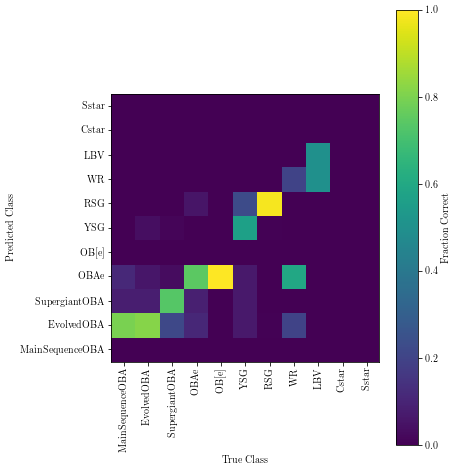

In [155]:
out_arr = []
possible_classes = ['MainSequenceOBA','EvolvedOBA','SupergiantOBA','OBAe','OB[e]','YSG',
                   'RSG','WR','LBV','Cstar','Sstar']
for true_class in possible_classes:
    sub_arr = []
    indices = y_test == true_class
    for classified in possible_classes:
        correct = y_check[(y_check == classified)&(y_test == true_class)]
        try:
            sub_arr.append(len(correct)/len(y_test[y_test==true_class]))
        except:
            sub_arr.append(0)
    out_arr.append(sub_arr)
out_arr = np.array(out_arr)
fig = plt.figure(figsize=(6,8))
plt.imshow(out_arr.T, origin='lower')
plt.yticks(ticks=np.arange(len(possible_classes)),labels=possible_classes)
plt.xticks(ticks=np.arange(len(possible_classes)),labels=possible_classes,rotation='vertical')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.colorbar(label='Fraction Correct')
plt.savefig('fraction_correct_colors_only.pdf');

In [156]:
unknown_index = [c in ['Unknown/Candidate','OBA','Misc. Variable'] 
                 for c in joined['Class'].values]
unknowns_data = joined[unknown_index][['G-J','J-H','H-K','K-W1','W1-W2','W2-W3','W3-W4','M_G','M_W1']].fillna(value=-999)
unknown_classes = tree.predict(unknowns_data)

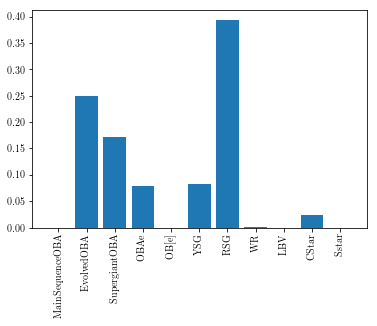

In [157]:
frac_output = []
pred_classes = ['MainSequenceOBA','EvolvedOBA','SupergiantOBA','OBAe','OB[e]','YSG',
                   'RSG','WR','LBV','CStar','Sstar']
for pred_class in pred_classes:
    frac = len(unknown_classes[unknown_classes == pred_class])/len(unknown_classes)
    frac_output.append(frac)
plt.bar(np.arange(len(pred_classes)),frac_output)
plt.xticks(ticks=np.arange(len(pred_classes)),labels=pred_classes,rotation='vertical');

In [161]:
from sklearn.ensemble import RandomForestClassifier
params = {'max_depth': np.arange(2,15,1),'n_estimators':np.arange(10,110,10)}
grid = GridSearchCV(RandomForestClassifier(n_jobs=-1), params, cv=4)
grid.fit(X_train, y_train)
    
forrest = grid.best_estimator_
max_depth = forrest.max_depth
n_estimators = forrest.n_estimators
print('Random Forest with max_depth set to :')
print(max_depth)
print('n_estimators set to')
print(n_estimators)
forrest.fit(X,y)
y_check = forrest.predict(X_test)

Random Forest with max_depth set to :
8
n_estimators set to
70


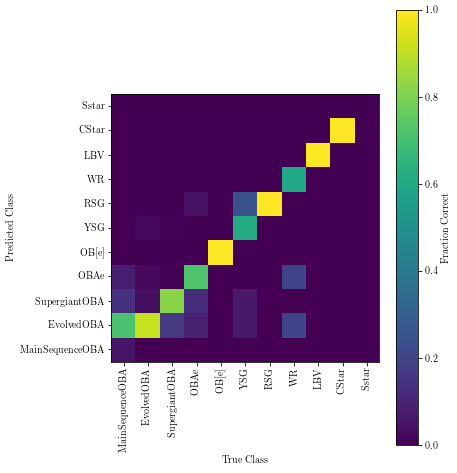

In [162]:
out_arr = []
possible_classes = ['MainSequenceOBA','EvolvedOBA','SupergiantOBA','OBAe','OB[e]','YSG',
                   'RSG','WR','LBV','CStar','Sstar']
for true_class in possible_classes:
    sub_arr = []
    indices = y_test == true_class
    for classified in possible_classes:
        correct = y_check[(y_check == classified)&(y_test == true_class)]
        try:
            sub_arr.append(len(correct)/len(y_test[y_test==true_class]))
        except:
            sub_arr.append(0)
    out_arr.append(sub_arr)
out_arr = np.array(out_arr)
fig = plt.figure(figsize=(6,8))
plt.imshow(out_arr.T, origin='lower')
plt.yticks(ticks=np.arange(len(possible_classes)),labels=possible_classes)
plt.xticks(ticks=np.arange(len(possible_classes)),labels=possible_classes,rotation='vertical')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.colorbar(label='Fraction Correct')
plt.savefig('fraction_correct_colors_only_RF.pdf');